In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, f_regression
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('./data/default of credit card clients.xls', header=1)

df = df.rename(columns = {'default payment next month': 'default'})
print (df.shape)
print(list(df.columns.values))
df.columns = [x.lower() for x in df.columns]
df.head()


(30000, 25)
['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default']


,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df['default'].value_counts()

0    23364
1     6636
Name: default, dtype: int64

In [4]:
df['default'].value_counts()/len(df)

0    0.7788
1    0.2212
Name: default, dtype: float64

In [5]:
df.marriage = df.marriage.map({2:2, 1:1, 3:3, 0:np.nan})
df['education'] = df.education.map({1:1, 2:2, 3:3, 4:4, 0:np.nan, 5:np.nan, 6:np.nan})
df.isnull().sum()

id             0
limit_bal      0
sex            0
education    345
marriage      54
age            0
pay_0          0
pay_2          0
pay_3          0
pay_4          0
pay_5          0
pay_6          0
bill_amt1      0
bill_amt2      0
bill_amt3      0
bill_amt4      0
bill_amt5      0
bill_amt6      0
pay_amt1       0
pay_amt2       0
pay_amt3       0
pay_amt4       0
pay_amt5       0
pay_amt6       0
default        0
dtype: int64

In [6]:
df.corr()['marriage']

id          -0.028871
limit_bal   -0.110498
sex         -0.030152
education   -0.147977
marriage     1.000000
age         -0.416497
pay_0        0.019380
pay_2        0.024105
pay_3        0.032824
pay_4        0.032733
pay_5        0.035280
pay_6        0.034025
bill_amt1   -0.025930
bill_amt2   -0.023697
bill_amt3   -0.027281
bill_amt4   -0.025576
bill_amt5   -0.027614
bill_amt6   -0.023386
pay_amt1    -0.005340
pay_amt2    -0.008895
pay_amt3    -0.003939
pay_amt4    -0.013440
pay_amt5    -0.002161
pay_amt6    -0.007600
default     -0.026224
Name: marriage, dtype: float64

In [7]:
from scipy.stats import chi2_contingency

def categories(series):
    return range(int(series.min()), int(series.max()) + 1)

def chi_sqr_dfcols(df, col1, col2):
    df_col1, df_col2 = df[col1], df[col2]
    
    result = [[sum((df_col1 == cat1) & (df_col2 == cat2))
              for cat2 in categories(df_col2)]
             for cat1 in categories(df_col1)]
    
    return chi2_contingency(result)

In [8]:
print(chi_sqr_dfcols(df, 'marriage', 'sex')[0:4])

(28.759379116902064, 5.688269617625994e-07, 2, array([[5415.98096574, 8243.01903426],
       [6329.94510118, 9634.05489882],
       [ 128.07393308,  194.92606692]]))


In [9]:
print(chi_sqr_dfcols(df, 'marriage', 'pay_0')[0:2])

(119.75140652451385, 3.170316500104624e-16)


In [10]:
df_v = df[np.isfinite(df['marriage'])]
df_v.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,1,20000,2,2.0,1.0,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2.0,2.0,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2.0,2.0,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2.0,1.0,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2.0,1.0,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [11]:
df_n = df[df['marriage'].isnull()==True]
df_n.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
218,219,110000,2,3.0,NaN,31,0,0,0,0,...,73315,63818,63208,4000,5000,3000,3000,3000,8954,0
809,810,160000,2,2.0,NaN,37,0,0,0,0,...,28574,27268,28021,35888,1325,891,1000,1098,426,0
820,821,200000,2,3.0,NaN,51,-1,-1,-1,-1,...,780,390,390,0,390,780,0,390,390,0
1019,1020,180000,2,3.0,NaN,45,-1,-1,-2,-2,...,0,0,0,0,0,0,0,0,0,0
1443,1444,200000,1,3.0,NaN,51,-1,-1,-1,-1,...,2529,1036,4430,5020,9236,2529,0,4430,6398,0


In [12]:
y_v = df_v.marriage
df_v = df_v.drop('marriage', axis=1)
df_n = df_n.drop('marriage', axis=1)

In [13]:
df_v = df_v[['age', 'sex', 'pay_0', 'pay_2', 'pay_3']]
df_n = df_n[['age', 'sex', 'pay_0', 'pay_2', 'pay_3']]

In [14]:
logreg = LogisticRegression()
logreg.fit(df_v, y_v)
mar_pred = logreg.predict(df_n)
mar_pred

array([2., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 1., 1., 2., 2., 1., 2.,
       1., 1., 1., 1., 1., 2., 1., 2., 1., 1., 2., 2., 2., 2., 2., 2., 1.,
       2., 2., 1., 1., 1., 2., 1., 2., 2., 2., 1., 2., 1., 2., 1., 1., 1.,
       1., 1., 1.])

In [15]:
df_n['marriage'] = mar_pred
df_n.head()

,age,sex,pay_0,pay_2,pay_3,marriage
218,31,2,0,0,0,2.0
809,37,2,0,0,0,1.0
820,51,2,-1,-1,-1,1.0
1019,45,2,-1,-1,-2,1.0
1443,51,1,-1,-1,-1,1.0


In [16]:
df_v['marriage'] = y_v
df_v = df_v[['marriage']]
df_n = df_n[['marriage']]
df_v.head()

,marriage
0,1.0
1,2.0
2,2.0
3,1.0
4,1.0


In [17]:
df_n.head()

,marriage
218,2.0
809,1.0
820,1.0
1019,1.0
1443,1.0


In [18]:
mars = pd.concat([df_v, df_n])
mars.sort_index(inplace=True)
df.marriage = mars

In [19]:
df.corr()['education']

id           0.030195
limit_bal   -0.244360
sex          0.012584
education    1.000000
marriage    -0.148182
age          0.187570
pay_0        0.123181
pay_2        0.142972
pay_3        0.136138
pay_4        0.128501
pay_5        0.115204
pay_6        0.102788
bill_amt1    0.004191
bill_amt2    0.000512
bill_amt3   -0.004419
bill_amt4   -0.015327
bill_amt5   -0.019113
bill_amt6   -0.016165
pay_amt1    -0.045338
pay_amt2    -0.038943
pay_amt3    -0.052136
pay_amt4    -0.043463
pay_amt5    -0.049799
pay_amt6    -0.053887
default      0.048248
Name: education, dtype: float64

In [20]:
print(chi_sqr_dfcols(df, 'education', 'sex')[0:2])
print(chi_sqr_dfcols(df, 'education', 'marriage')[0:2])
print(chi_sqr_dfcols(df, 'education', 'pay_0')[0:2])
print(chi_sqr_dfcols(df, 'education', 'pay_2')[0:2])

(23.3090352449779, 3.481513503146472e-05)
(1008.7751670394927, 1.1310363876765278e-214)
(1182.4880825287928, 1.2609302976502225e-229)
(1376.760857338455, 6.890955672231062e-271)


In [21]:
df_v = df[np.isfinite(df['education'])]
df_v.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,1,20000,2,2.0,1.0,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2.0,2.0,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2.0,2.0,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2.0,1.0,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2.0,1.0,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [22]:
df_n = df[df['education'].isnull() == True]
df_n.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
47,48,150000,2,NaN,2.0,46,0,0,-1,0,...,1170,0,0,1013,1170,0,0,0,0,1
69,70,20000,1,NaN,2.0,22,2,0,0,0,...,18085,11205,5982,0,1200,1000,500,1000,0,0
385,386,410000,2,NaN,1.0,42,0,0,0,0,...,240865,234939,240176,15000,14000,9000,8500,9000,8300,0
502,503,230000,2,NaN,2.0,46,0,0,0,0,...,186635,189896,193351,10000,9000,8000,8000,7500,7000,0
504,505,30000,1,NaN,1.0,53,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0


In [23]:
y_v = df_v.education
df_v = df_v.drop('education', axis=1)
df_n = df_n.drop('education', axis=1)
df_v = df_v[['age', 'sex', 'marriage', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5']]
df_n = df_n[['age', 'sex', 'marriage', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5']]

In [24]:
logreg = LogisticRegression()
logreg.fit(df_v, y_v)
edu_pred = logreg.predict(df_n)
edu_pred

array([2., 2., 2., 2., 1., 3., 2., 2., 2., 1., 2., 2., 1., 1., 2., 2., 2.,
       3., 2., 2., 2., 2., 1., 1., 2., 2., 2., 1., 1., 2., 2., 2., 1., 1.,
       2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 2., 3., 2., 2., 2., 2., 2.,
       2., 1., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2.,
       2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2.,
       1., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 1., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 1., 2., 2., 2., 1.,
       1., 1., 2., 2., 1., 1., 2., 2., 1., 2., 1., 2., 1., 1., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 1., 2., 2., 1., 1., 3.,
       2., 1., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 1., 2., 2., 2., 1., 2., 2., 1., 1., 1., 2., 2., 2., 1., 2.,
       2., 2., 2., 1., 1., 2., 2., 2., 3., 2., 2., 2., 2., 2., 1., 2., 1.,
       1., 2., 1., 2., 1., 2., 2., 2., 3., 3., 2., 2., 2., 2., 1., 2., 2.,
       2., 2., 2., 2., 2.

In [25]:
df_n['education'] = edu_pred
df_v['education'] = y_v
df_v = df_v[['education']]
df_n = df_n[['education']]
edu = pd.concat([df_v, df_n])
edu.sort_index(inplace=True)
df.education = edu
df.isnull().sum()

id           0
limit_bal    0
sex          0
education    0
marriage     0
age          0
pay_0        0
pay_2        0
pay_3        0
pay_4        0
pay_5        0
pay_6        0
bill_amt1    0
bill_amt2    0
bill_amt3    0
bill_amt4    0
bill_amt5    0
bill_amt6    0
pay_amt1     0
pay_amt2     0
pay_amt3     0
pay_amt4     0
pay_amt5     0
pay_amt6     0
default      0
dtype: int64

In [26]:
df.describe()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.816833,1.554500,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.708919,0.518239,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


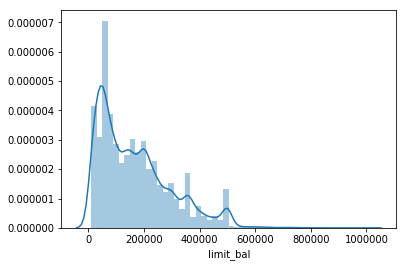

In [27]:
sns.distplot(df['limit_bal'], kde=True)

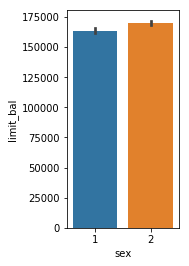

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(2, 4)
sns.barplot(x='sex', y='limit_bal', data=df, ax=ax)

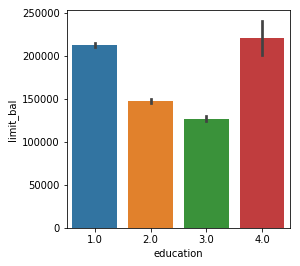

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(4, 4)
sns.barplot(x='education', y='limit_bal', data=df, ax=ax)

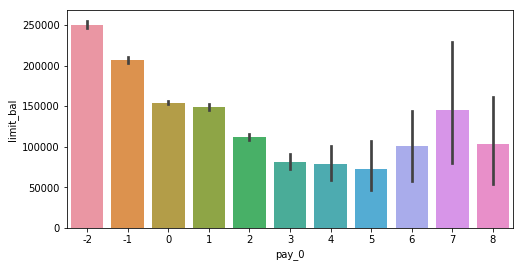

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
sns.barplot(x='pay_0', y='limit_bal', data=df, ax=ax)

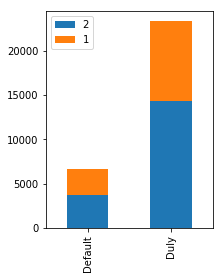

In [31]:
default_sex = df[df['default']==1]['sex'].value_counts()
duly_sex = df[df['default']==0]['sex'].value_counts()
df_def_sex = pd.DataFrame([default_sex, duly_sex])
df_def_sex.index = ['Default', 'Duly']
df_def_sex.plot(kind='bar', stacked=True, figsize=(3, 4))

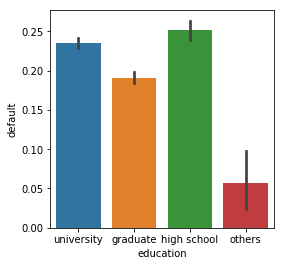

In [32]:
df.sex = df.sex.map({1:'male', 2:'female'})
df['education'] = df.education.map({1:'graduate', 2:'university', 3:'high school', 
                                    4:'others', 5:'unknown', 6: 'unknown', 0:'Illiterate'})
fig, ax = plt.subplots()
fig.set_size_inches(4, 4)
sns.barplot(x='education', y='default', data=df, ax=ax)

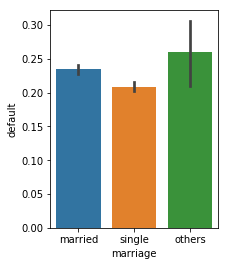

In [33]:
df['marriage'] = df.marriage.map({1:'married', 2:'single', 3:'others', 0:'unknown'})
fig, ax = plt.subplots()
fig.set_size_inches(3, 4)
sns.barplot(x='marriage', y='default', data=df, ax=ax)

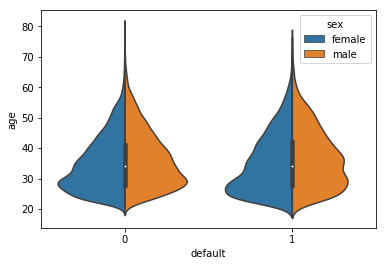

In [34]:
sns.violinplot(x='default', y='age', hue='sex', data=df, split=True)

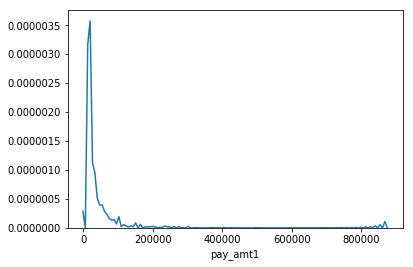

In [35]:
sns.distplot(df['pay_amt1'], hist=False, kde=True)

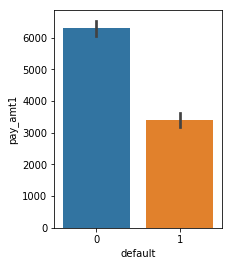

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(3, 4)
sns.barplot(x='default', y='pay_amt1', data=df, ax=ax)

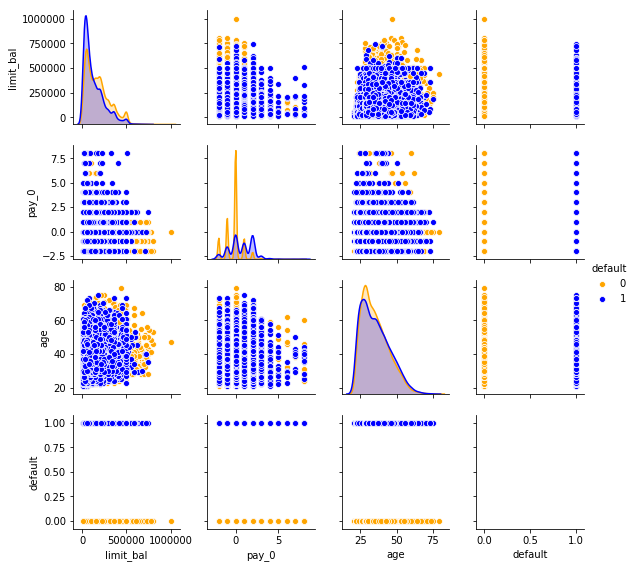

In [37]:
sns.pairplot(df[['sex', 'limit_bal', 'education', 'pay_0', 'age', 'default']], 
             hue='default', size=2, palette={1:'blue', 0:'orange'})

In [38]:
df.columns

Index(['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0',
       'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'default'],
      dtype='object')

In [39]:
df['paybill1'] = df['bill_amt1'] * df['pay_0']
df['paybill2'] = df['bill_amt2'] * df['pay_2']
df['paybill3'] = df['bill_amt3'] * df['pay_3']
df['paybill4'] = df['bill_amt4'] * df['pay_4']
df['paybill5'] = df['bill_amt5'] * df['pay_5']
df['paybill6'] = df['bill_amt6'] * df['pay_6']

In [40]:
df['paypay1'] = df['pay_amt1'] * df['pay_0']
df['paypay2'] = df['pay_amt2'] * df['pay_2']
df['paypay3'] = df['pay_amt3'] * df['pay_3']
df['paypay4'] = df['pay_amt4'] * df['pay_4']
df['paypay5'] = df['pay_amt5'] * df['pay_5']
df['paypay6'] = df['pay_amt6'] * df['pay_6']

In [85]:
import statsmodels.api as sm
Cols = df.columns
for col in Cols:
    df_pval = sm.OLS(endog=df['default'].values, exog=df[col].values).fit()
    print(df_pval.summary())

#     print('{}: {}'.format(col, df_pval.f_pvalue))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     2731.
Date:                Sun, 10 Feb 2019   Prob (F-statistic):               0.00
Time:                        14:18:13   Log-Likelihood:                -18631.
No. Observations:               30000   AIC:                         3.726e+04
Df Residuals:                   29999   BIC:                         3.727e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          6.412e-07   1.23e-08     52.254      0.0

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [42]:
df[['limit_bal', 'marriage', 'education', 'pay_0', 'pay_2', 'pay_3', 'bill_amt1', 'bill_amt2', 'bill_amt3',
   'paybill1', 'paybill2', 'paybill3', 'paybill4', 'paybill5', 'paybill6', 'default']].corr()

,limit_bal,pay_0,pay_2,pay_3,bill_amt1,bill_amt2,bill_amt3,paybill1,paybill2,paybill3,paybill4,paybill5,paybill6,default
limit_bal,1.000000,-0.271214,-0.296382,-0.286123,0.285430,0.278314,0.283236,-0.007089,-0.021389,-0.041870,-0.059848,-0.052143,-0.050414,-0.153520
pay_0,-0.271214,1.000000,0.672164,0.574245,0.187068,0.189859,0.179785,0.487506,0.418755,0.351143,0.317305,0.293100,0.256419,0.324794
pay_2,-0.296382,0.672164,1.000000,0.766552,0.234887,0.235257,0.224146,0.387908,0.488559,0.388882,0.341192,0.315568,0.275918,0.263551
pay_3,-0.286123,0.574245,0.766552,1.000000,0.208473,0.237295,0.227494,0.298772,0.355999,0.464904,0.372191,0.322261,0.286981,0.235253
bill_amt1,0.285430,0.187068,0.234887,0.208473,1.000000,0.951484,0.892279,0.282210,0.265612,0.219987,0.170994,0.165299,0.166083,-0.019644
bill_amt2,0.278314,0.189859,0.235257,0.237295,0.951484,1.000000,0.928326,0.295818,0.256172,0.249528,0.191518,0.183779,0.184468,-0.014193
bill_amt3,0.283236,0.179785,0.224146,0.227494,0.892279,0.928326,1.000000,0.286169,0.261712,0.192420,0.215957,0.199074,0.192240,-0.014076
paybill1,-0.007089,0.487506,0.387908,0.298772,0.282210,0.295818,0.286169,1.000000,0.814468,0.647730,0.523472,0.468316,0.378763,0.222866
paybill2,-0.021389,0.418755,0.488559,0.355999,0.265612,0.256172,0.261712,0.814468,1.000000,0.743852,0.602218,0.539470,0.434284,0.195397
paybill3,-0.041870,0.351143,0.388882,0.464904,0.219987,0.249528,0.192420,0.647730,0.743852,1.000000,0.701466,0.592975,0.505534,0.177741


In [43]:
df.drop('id', axis=1, inplace=True)

In [44]:
def onehot_encode(df, col):
    vec = DictVectorizer()
    vec_data  = pd.DataFrame(vec.fit_transform(df[col].to_dict('records')).toarray())
    vec_data.columns = vec.get_feature_names()
    vec_data.index = df.index
    
    df = df.drop(col, axis=1)
    df = df.join(vec_data)
    return df

In [45]:
X = onehot_encode(df, col=['sex'])
X = onehot_encode(X, col=['education'])
X = onehot_encode(X, col=['marriage'])
X.columns

Index(['limit_bal', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5',
       'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4',
       'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3',
       'pay_amt4', 'pay_amt5', 'pay_amt6', 'default', 'paybill1', 'paybill2',
       'paybill3', 'paybill4', 'paybill5', 'paybill6', 'paypay1', 'paypay2',
       'paypay3', 'paypay4', 'paypay5', 'paypay6', 'sex=female', 'sex=male',
       'education=graduate', 'education=high school', 'education=others',
       'education=university', 'marriage=married', 'marriage=others',
       'marriage=single'],
      dtype='object')

In [46]:
y = df.default
X = X.drop(['default'], axis=1)
X.shape

(30000, 41)

In [47]:
X[['sex=female', 'sex=male', 
   'education=high school', 'education=others', 'education=university', 'education=graduate', 
   'marriage=married', 'marriage=others', 'marriage=single']].replace(0, -1, inplace=True)

In [48]:
X_trainset, X_testset, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [49]:
scaler1 = StandardScaler()
scaler1.fit(X_trainset)
X_trainset = scaler1.transform(X_trainset)
X_trainset.shape

(24000, 41)

In [50]:
scaler2 = StandardScaler()
scaler2.fit(X_testset)
X_test = scaler2.transform(X_testset)
X_test.shape


(6000, 41)

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, make_scorer
def fit_classifier(model, X, y, model_type=None, parameters=None, scorer_metrics=None):
    grid_obj = GridSearchCV(estimator=model, param_grid=parameters, scoring=make_scorer(scorer_metrics), cv=3)
    grid_fit = grid_obj.fit(X, y)
    
    train_means = grid_fit.cv_results_['mean_train_score']
    train_stds = grid_fit.cv_results_['std_train_score']
    test_means = grid_fit.cv_results_['mean_test_score']
    test_stds = grid_fit.cv_results_['std_test_score']
    for train_mean, train_std, test_mean, test_std, params in \
        zip(train_means, train_stds, test_means, test_stds, grid_fit.cv_results_['params']):
        print("train: %0.3f (+/-%0.3f); test: %0.3f (+/-%0.3f) for %r" \
              %(train_mean, train_std*2, test_mean, test_std*2, params))
  
    model_estimator = grid_fit.best_estimator_
    model_estimator.fit(X, y)
    y_pred = model_estimator.predict(X)

    print("\n")
    print("\nModel performance on training set\n----------------")
    print("Final accuracy score on the training data: {:.4f}".format(accuracy_score(y, y_pred)))
    print("Final precision score on training data: {:.4f}".format(precision_score(y, y_pred)))
    print("Final recall score on training data: {:.4f}".format(recall_score(y, y_pred)))
    print("Final ROC AUC score on training data: {:.4f}".format(roc_auc_score(y, y_pred)))
    print("\n")
    print("The best parameters are: {}".format(model_estimator))
    
    best_params = model_estimator.get_params()
    if (model_type == "DT"):
        return best_params.get('max_depth'), best_params.get('min_samples_leaf'), best_params.get('min_samples_split')
    if(model_type == "ADB"):
        return best_params.get('learning_rate'), best_params.get('n_estimators'), best_params.get('min_samples_split'),\
                best_params.get('min_samples_leaf')
    if(model_type == "SVM"):
        return best_params.get('kernel'), best_params.get('class_weight')
    if(model_type == "KNN"):
        return best_params.get('n_neighbors')

    return model_estimator

In [51]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(train_sizes, train_scores, valid_scores):
#     train_sizes, train_scores, valid_scores = learning_curve( \
#         model, X_train, y_train, train_sizes=train_sizes, cv=3)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores,axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std,  alpha=0.1, color='r')
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, 
                     valid_scores_mean + valid_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label = 'Training Score')
    plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label = 'Cross-validation score')
    plt.legend(loc='best')
    plt.show()


In [52]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import itertools
def plot_confusion_matrix(confusion_matrix=None):
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    num_class = ["not subscribe", "subscribe"]
    plt.title("BM confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(num_class))
    plt.xticks(tick_marks, num_class, rotation=45)
    plt.yticks(tick_marks, num_class)

    fmt = 'd'
    thresh = confusion_matrix.max() / 2.0
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if confusion_matrix[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [53]:
accuracy_score = []
avail_sizes = np.linspace(0.1, 1, num=10)

In [89]:
from sklearn.tree import DecisionTreeClassifier
parameters_DT = {'max_depth': [6, 7, 8],
                 'min_samples_leaf': [2, 3],
                 'min_samples_split': [2, 3]}
maxdepth, minleaf, minsplit = fit_classifier(DecisionTreeClassifier(random_state=18), X_trainset, y_train, model_type="DT",
                          parameters=parameters_DT, scorer_metrics=recall_score)
print ("%d, %d, %d" % (maxdepth, minleaf, minsplit))

train: 0.400 (+/-0.009); test: 0.373 (+/-0.024) for {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}
train: 0.400 (+/-0.009); test: 0.373 (+/-0.024) for {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 3}
train: 0.400 (+/-0.009); test: 0.373 (+/-0.025) for {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 2}
train: 0.400 (+/-0.009); test: 0.373 (+/-0.025) for {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 3}
train: 0.421 (+/-0.005); test: 0.379 (+/-0.029) for {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2}
train: 0.421 (+/-0.005); test: 0.379 (+/-0.029) for {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 3}
train: 0.421 (+/-0.005); test: 0.379 (+/-0.030) for {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 2}
train: 0.421 (+/-0.005); test: 0.379 (+/-0.030) for {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 3}
train: 0.435 (+/-0.022); test: 0.369 (+/-0.015) for {'max_depth': 8, 'mi

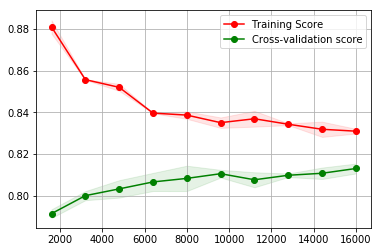

In [54]:
from sklearn.tree import DecisionTreeClassifier

# from sklearn.model_selection import learning_curve
dtc = DecisionTreeClassifier(max_depth=7, min_samples_split=2, min_samples_leaf=2, random_state=17)
train_sizes, train_scores, valid_scores = learning_curve(dtc, X_trainset, y_train, train_sizes=avail_sizes, cv=3)
# plot_learning_curve(dtc, X_train, y_train, train_sizes=avail_sizes, cv=3)
plot_learning_curve(train_sizes, train_scores, valid_scores)

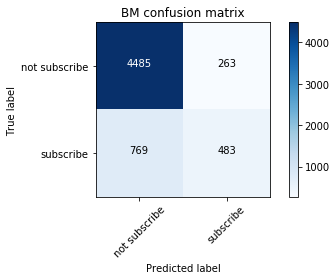

In [55]:
dtc.fit(X_trainset, y_train)
confusion_matrix_DT = confusion_matrix(y_test, dtc.predict(X_test))
plot_confusion_matrix(confusion_matrix_DT)

(24000, 10)
['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'paybill1', 'paybill2', 'paybill3', 'paybill5']


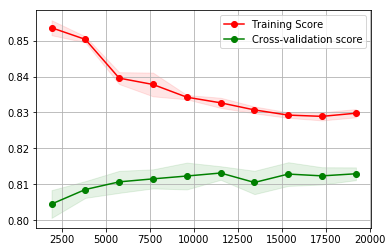

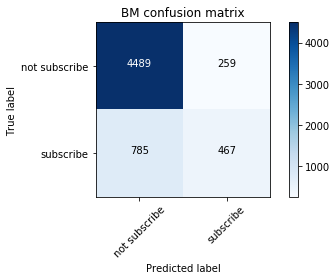

0.826
(24000, 11)
['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'paybill1', 'paybill2', 'paybill3', 'paybill4', 'paybill5']


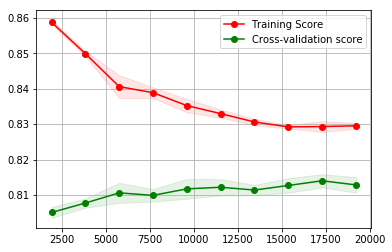

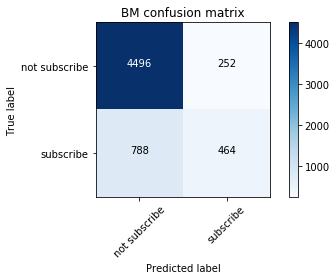

0.8266666666666667
(24000, 12)
['limit_bal', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'paybill1', 'paybill2', 'paybill3', 'paybill4', 'paybill5']


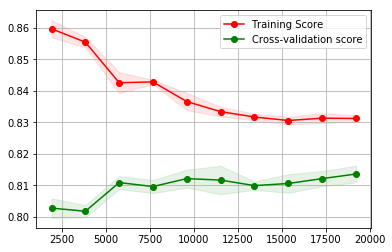

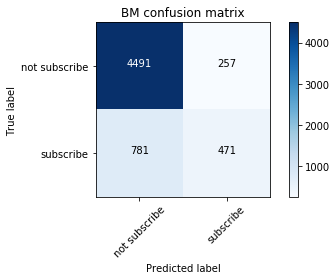

0.827
(24000, 13)
['limit_bal', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'paybill1', 'paybill2', 'paybill3', 'paybill4', 'paybill5', 'paybill6']


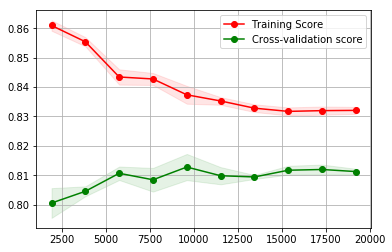

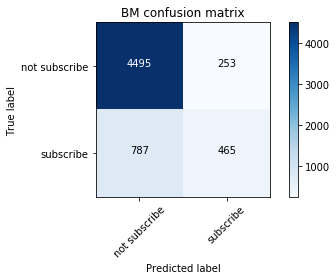

0.8266666666666667
(24000, 14)
['limit_bal', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'paybill1', 'paybill2', 'paybill3', 'paybill4', 'paybill5', 'paybill6', 'paypay1']


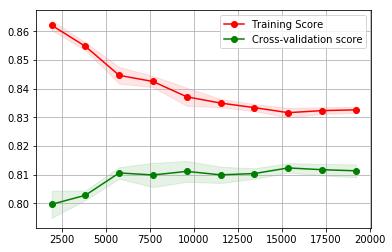

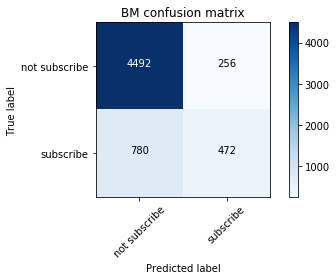

0.8273333333333334
(24000, 15)
['limit_bal', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'pay_amt1', 'paybill1', 'paybill2', 'paybill3', 'paybill4', 'paybill5', 'paybill6', 'paypay1']


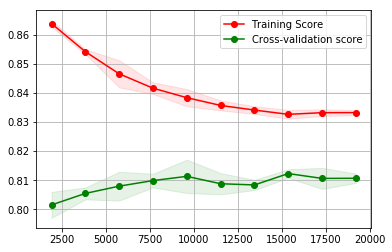

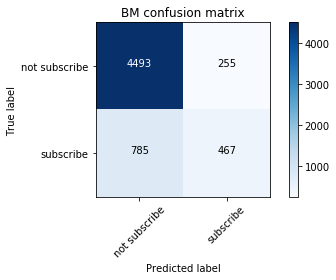

0.8266666666666667
(24000, 16)
['limit_bal', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'pay_amt1', 'paybill1', 'paybill2', 'paybill3', 'paybill4', 'paybill5', 'paybill6', 'paypay1', 'paypay3']


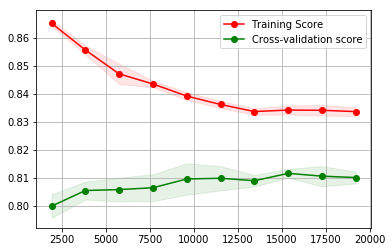

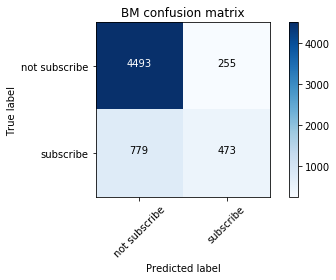

0.8276666666666667
(24000, 17)
['limit_bal', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'pay_amt1', 'paybill1', 'paybill2', 'paybill3', 'paybill4', 'paybill5', 'paybill6', 'paypay1', 'paypay3', 'paypay4']


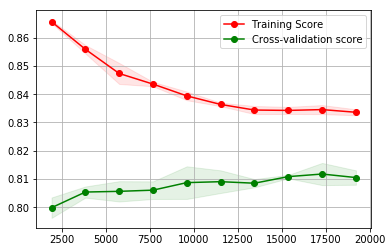

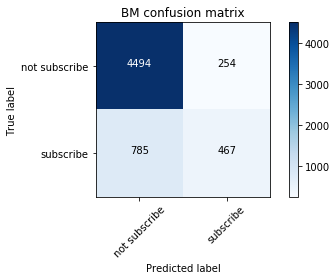

0.8268333333333333


[0.826,
 0.8266666666666667,
 0.827,
 0.8266666666666667,
 0.8273333333333334,
 0.8266666666666667,
 0.8276666666666667,
 0.8268333333333333]

In [58]:
accuracy_score = []
avail_sizes = np.linspace(0.1, 1, num=10)

import random
random.seed()

for i in range (10, 18):
    selector = SelectKBest(score_func=f_regression, k=i)
    X_trainset_trans = selector.fit_transform(X_trainset, y_train)
    print(X_trainset_trans.shape)
    print(X.columns[selector.get_support(indices=True)].tolist())
    
#     X_train, X_test, y_train, y_test = train_test_split(X_trainset_mod, y_trainset, test_size=0.2, random_state=17)
   
    dtc = DecisionTreeClassifier(max_depth=8, min_samples_split=2, min_samples_leaf=2)
    
    train_sizes, train_scores, valid_scores = learning_curve(dtc, X_trainset_trans, y_train, train_sizes=avail_sizes, cv=5)

    plot_learning_curve(train_sizes, train_scores, valid_scores)
    
    dtc.fit(X_trainset, y_train)
    confusion_matrix_DT = confusion_matrix(y_test, dtc.predict(X_test))
    plot_confusion_matrix(confusion_matrix_DT)
    
#     svc.fit(X_train, y_train)
    y_pred = dtc.predict(X_test)
    print(metrics.accuracy_score(y_test, y_pred))
    accuracy_score.append(metrics.accuracy_score(y_test, y_pred))

accuracy_score

In [91]:
from sklearn import svm
parameters_svm = {'kernel':['rbf', 'sigmoid'],
                  'class_weight': [{1:1}, {1:5}],
                  'random_state': [18]}
opt_kernel, opt_class_weight = fit_classifier(
                        svm.SVC(), X_trainset, y_train, model_type="SVM",
                        parameters=parameters_svm, scorer_metrics=recall_score)
print (opt_kernel)
print(opt_class_weight)

train: 0.348 (+/-0.014); test: 0.319 (+/-0.008) for {'class_weight': {1: 1}, 'kernel': 'rbf', 'random_state': 18}
train: 0.380 (+/-0.051); test: 0.387 (+/-0.050) for {'class_weight': {1: 1}, 'kernel': 'sigmoid', 'random_state': 18}
train: 0.807 (+/-0.026); test: 0.730 (+/-0.014) for {'class_weight': {1: 5}, 'kernel': 'rbf', 'random_state': 18}
train: 0.671 (+/-0.032); test: 0.674 (+/-0.015) for {'class_weight': {1: 5}, 'kernel': 'sigmoid', 'random_state': 18}



Model performance on training set
----------------
Final accuracy score on the training data: 0.6795
Final precision score on training data: 0.3951
Final recall score on training data: 0.8072
Final ROC AUC score on training data: 0.7249


The best parameters are: SVC(C=1.0, cache_size=200, class_weight={1: 5}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=18,
  shrinking=True, tol=0.001, verbose=False)
rbf
{1: 5}


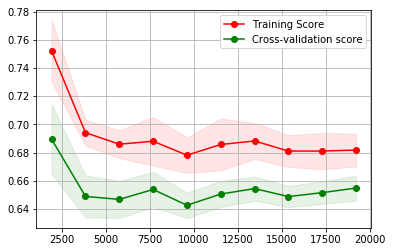

In [101]:
avail_sizes = np.linspace(0.1, 1, num=10)
svc = SVC(kernel=opt_kernel, class_weight=opt_class_weight)

train_sizes, train_scores, valid_scores = learning_curve(svc, X_trainset, y_train, train_sizes=avail_sizes, cv=5)
# print('learning_curve finished, start plotting')

plot_learning_curve(train_sizes, train_scores, valid_scores)


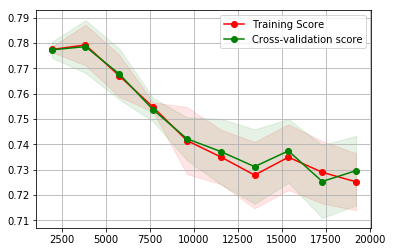

In [94]:
avail_sizes = np.linspace(0.1, 1, num=10)
svc = SVC(kernel='sigmoid', class_weight={1:1})

train_sizes, train_scores, valid_scores = learning_curve(svc, X_trainset, y_train, train_sizes=avail_sizes, cv=5)
# print('learning_curve finished, start plotting')

plot_learning_curve(train_sizes, train_scores, valid_scores)

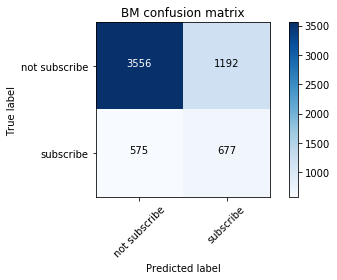

In [64]:
svc = SVC(kernel='sigmoid', class_weight={1:2})

svc.fit(X_trainset, y_train)

confusion_matrix_SVM = confusion_matrix(y_test, svc.predict(X_test))
plot_confusion_matrix(confusion_matrix_SVM)

In [ ]:
# accuracy_score = []
# avail_sizes = np.linspace(0.1, 1, num=3)
# for i in range (15, 18):
#     selector = SelectKBest(score_func=f_regression, k=i)
#     X_trainset_trans = selector.fit_transform(X_trainset, y_train)
#     print(X_trainset_trans.shape)
#     print(X.columns[selector.get_support(indices=True)].tolist())
    
# #     X_train, X_test, y_train, y_test = train_test_split(X_trainset_mod, y_trainset, test_size=0.2, random_state=17)
   
#     svc = SVC(kernel='linear')
    
#     train_sizes, train_scores, valid_scores = learning_curve(svc, X_trainset_trans, y_train, train_sizes=avail_sizes, cv=3)
#     print('learning_curve finished, start plotting')
#     plot_learning_curve(train_sizes, train_scores, valid_scores)
    
#     confusion_matrix_SVM = confusion_matrix(y_test, svc.predict(X_test))
#     plot_confusion_matrix(confusion_matrix_SVM)
    
# #     svc.fit(X_train, y_train)
#     y_pred = svc.predict(X_test)
#     print(metrics.accuracy_score(y_test, y_pred))
#     accuracy_score.append(metrics.accuracy_score(y_test, y_pred))

# accuracy_score

In [102]:
from sklearn.ensemble import AdaBoostClassifier
parameters_ADB = {'learning_rate': [0.2, 0.3, 0.6],
                 'n_estimators': [50, 100],
#                  'min_samples_split': [2, 3],
#                  'min_samples_leaf': [2, 3]
                }
lr, n_estimators, minsplit_gb, minleaf_gb = fit_classifier(
                        AdaBoostClassifier(random_state=18), X_trainset, y_train, model_type="ADB",
                        parameters=parameters_ADB, scorer_metrics=recall_score)
# print ("%.3f, %d, %d, %d" % (lr, n_estimators, minsplit_gb, minleaf_gb))

train: 0.345 (+/-0.008); test: 0.342 (+/-0.018) for {'learning_rate': 0.2, 'n_estimators': 50}
train: 0.353 (+/-0.004); test: 0.352 (+/-0.018) for {'learning_rate': 0.2, 'n_estimators': 100}
train: 0.353 (+/-0.008); test: 0.353 (+/-0.015) for {'learning_rate': 0.3, 'n_estimators': 50}
train: 0.358 (+/-0.008); test: 0.353 (+/-0.015) for {'learning_rate': 0.3, 'n_estimators': 100}
train: 0.350 (+/-0.020); test: 0.349 (+/-0.014) for {'learning_rate': 0.6, 'n_estimators': 50}
train: 0.358 (+/-0.020); test: 0.349 (+/-0.017) for {'learning_rate': 0.6, 'n_estimators': 100}



Model performance on training set
----------------
Final accuracy score on the training data: 0.8188
Final precision score on training data: 0.6832
Final recall score on training data: 0.3588
Final ROC AUC score on training data: 0.6554


The best parameters are: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.3, n_estimators=100, random_state=18)


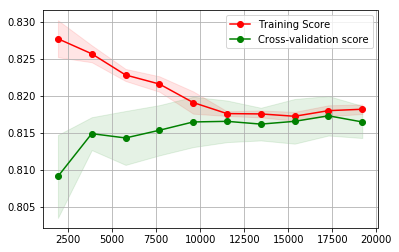

In [103]:
from sklearn.ensemble import AdaBoostClassifier

adb = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=lr)
avail_sizes = np.linspace(0.1, 1, num=10)

train_sizes, train_scores, valid_scores = learning_curve(adb, X_trainset, y_train, train_sizes=avail_sizes, cv=5)
# print('learning_curve finished, start plotting')

plot_learning_curve(train_sizes, train_scores, valid_scores)

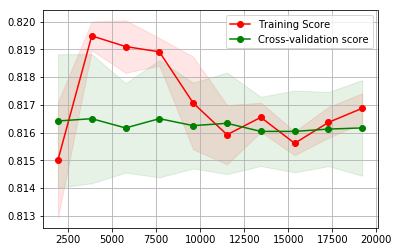

In [71]:
from sklearn.ensemble import AdaBoostClassifier

adb = AdaBoostClassifier(n_estimators=79, learning_rate=lr)
avail_sizes = np.linspace(0.1, 1, num=10)

train_sizes, train_scores, valid_scores = learning_curve(adb, X_trainset, y_train, train_sizes=avail_sizes, cv=5)
# print('learning_curve finished, start plotting')

plot_learning_curve(train_sizes, train_scores, valid_scores)

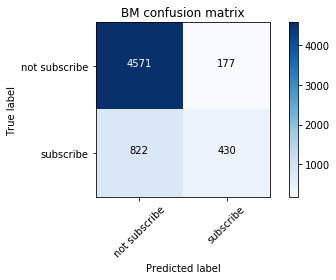

In [70]:
# adb = AdaBoostClassifier(n_estimator=49, learning_rate=0.01)

adb.fit(X_trainset, y_train)

confusion_matrix_ADB = confusion_matrix(y_test, adb.predict(X_test))
plot_confusion_matrix(confusion_matrix_ADB)

In [95]:
from sklearn.neighbors import KNeighborsClassifier
parameters_knn = {'n_neighbors':[17, 27, 51, 75]}
opt_n_neighbors = fit_classifier(
                        KNeighborsClassifier(), X_trainset, y_train, model_type="KNN",
                        parameters=parameters_knn, scorer_metrics=recall_score)
print(opt_n_neighbors)

train: 0.348 (+/-0.008); test: 0.318 (+/-0.017) for {'n_neighbors': 17}
train: 0.318 (+/-0.007); test: 0.300 (+/-0.019) for {'n_neighbors': 27}
train: 0.288 (+/-0.002); test: 0.280 (+/-0.019) for {'n_neighbors': 51}
train: 0.270 (+/-0.003); test: 0.266 (+/-0.021) for {'n_neighbors': 75}



Model performance on training set
----------------
Final accuracy score on the training data: 0.8204
Final precision score on training data: 0.6878
Final recall score on training data: 0.3650
Final ROC AUC score on training data: 0.6585


The best parameters are: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=17, p=2,
           weights='uniform')
17


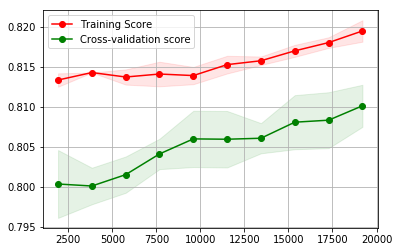

In [104]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=opt_n_neighbors)
avail_sizes = np.linspace(0.1, 1, num=10)

train_sizes, train_scores, valid_scores = learning_curve(knn, X_trainset, y_train, train_sizes=avail_sizes, cv=5)
# print('learning_curve finished, start plotting')

plot_learning_curve(train_sizes, train_scores, valid_scores)

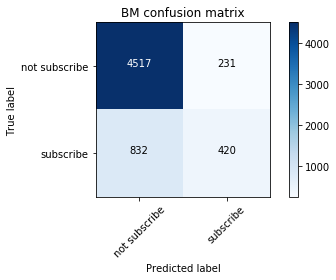

In [73]:
knn.fit(X_trainset, y_train)

confusion_matrix_KNN = confusion_matrix(y_test, knn.predict(X_test))
plot_confusion_matrix(confusion_matrix_KNN)

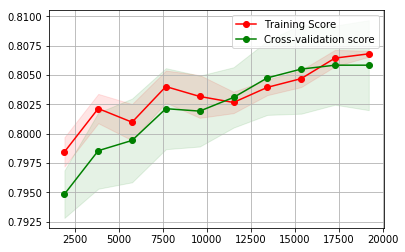

In [74]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=79)
avail_sizes = np.linspace(0.1, 1, num=10)

train_sizes, train_scores, valid_scores = learning_curve(knn, X_trainset, y_train, train_sizes=avail_sizes, cv=5)
# print('learning_curve finished, start plotting')

plot_learning_curve(train_sizes, train_scores, valid_scores)

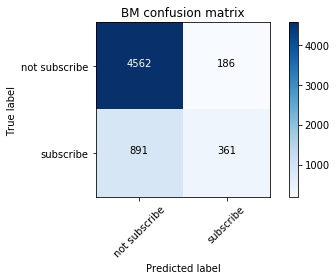

In [75]:
knn.fit(X_trainset, y_train)

confusion_matrix_KNN = confusion_matrix(y_test, knn.predict(X_test))
plot_confusion_matrix(confusion_matrix_KNN)

In [76]:
from sklearn.model_selection import train_test_split
random.seed()

# convert pandas dataframe to numpy array. Keras does not support pandas dataframe
X_train_NN, X_val_NN, y_train_NN, y_val_NN = train_test_split(X_trainset, y_train.values,
                                                              test_size=0.2, random_state=31)

In [77]:
import keras.backend as K
# from sklearn.metrics import recall_score

def recall(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

Using TensorFlow backend.


In [83]:
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper right')
    
    plt.show()
    
def plot_recall(hist):
    plt.plot(hist.history['recall'])
    plt.plot(hist.history['val_recall'])
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='lower right')
    
    plt.show()

In [105]:
from keras.callbacks import ModelCheckpoint

def fit_NNClassifier(parameters, X_train, y_train, X_val, y_val, 
                     input_shape, epochs=40, batch_size=40, metrics=recall):
    for activation in parameters.get('activation'): 
        for optimizer in parameters.get('optimizer'):
            for hidden in parameters.get('hiddens'):
                nnm = Sequential()
                nnm.add(Dense(hidden, activation=activation, input_shape=(input_shape, )))  # X_train_NN.shape[1] = 63
                nnm.add(Dropout(.2))
                nnm.add(Dense(1, activation=activation))


                nnm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metrics])
                nnm.summary()

                filepath = '';
                if (isinstance(optimizer, str)):
                    filepath = 'weights_best_' + activation + '_' + optimizer + '.hdf5'
                else:
                    filepath = 'weights_best_' + activation + '_' + \
                        str(type(optimizer)).strip('<>\'').split('.')[-1] + '.hdf5'
                    
                checkpointer = ModelCheckpoint(filepath, monitor=recall, verbose=0, save_best_only=False, mode='max')
                print('############################################')
                history = nnm.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=0)
                print (history.history)
                plot_loss(history)
                plot_recall(history)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 64)                2688      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________
############################################
{'val_loss': [0.46944554820656775, 0.4642701730132103, 0.46301462563375634, 0.4615001219014327, 0.4591884508728981, 0.4606513471653064, 0.45869610520700616, 0.45738072581589223, 0.45571683943271635, 0.4572137831399838, 0.45476485763986907, 0.45543452550967534, 0.4546481415629387, 0.454561160504818, 0.45528174452483655, 0.45556196284790834, 0.456395769864320

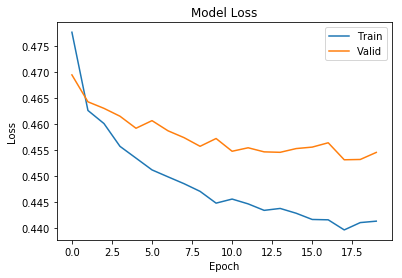

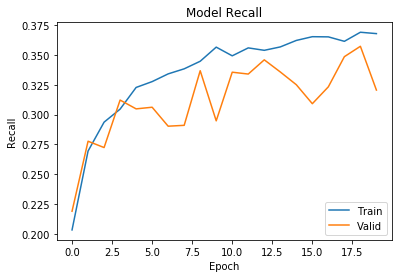

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 32)                1344      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 1,377
Trainable params: 1,377
Non-trainable params: 0
_________________________________________________________________
############################################
{'val_loss': [0.46921602115035055, 0.466896553337574, 0.4648184244831403, 0.46331393271684645, 0.46098441978295646, 0.46022283981243767, 0.4586840242147446, 0.45760197589794793, 0.4572526826212803, 0.4565014066795508, 0.45614771408339344, 0.45559946782886984, 0.4550480385621389, 0.45474100795884925, 0.4546564588944117, 0.45437248398860297, 0.453480840226014

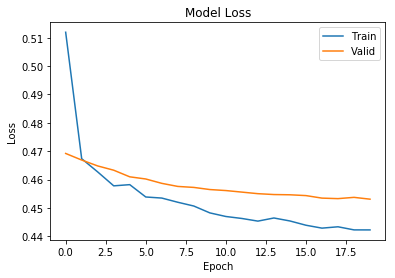

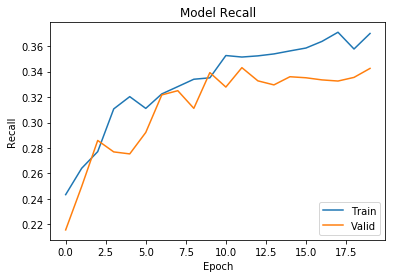

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 64)                2688      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________
############################################
{'val_loss': [0.5003166166444619, 0.48602359741926193, 0.47963024949034055, 0.47731285194555917, 0.4749058114985625, 0.4732462746401628, 0.4722395976384481, 0.47196225821971893, 0.4710275967915853, 0.4708520670731862, 0.4702673765520255, 0.46997799078623453, 0.4695166625082493, 0.4692623903354009, 0.46907437046368916, 0.4690373455484708, 0.4690977764626344,

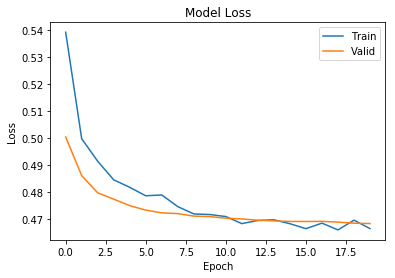

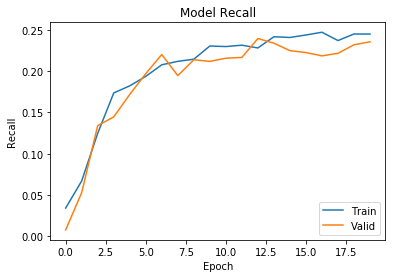

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 32)                1344      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 33        
Total params: 1,377
Trainable params: 1,377
Non-trainable params: 0
_________________________________________________________________
############################################
{'val_loss': [0.5137263149023056, 0.49592584123214084, 0.48721904630462326, 0.4826802643636862, 0.47940691659847895, 0.4773144828776518, 0.4757908197740714, 0.4752398851017157, 0.4738833226263523, 0.47327115560571353, 0.4723079649110635, 0.47194092323382697, 0.4713318310678005, 0.47093154390652975, 0.4705886848270893, 0.47059638276696203, 0.4701640062034130

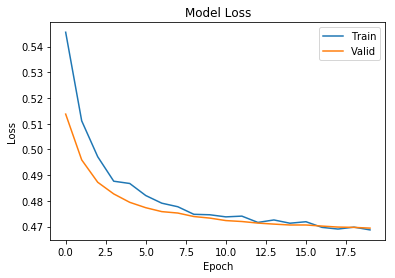

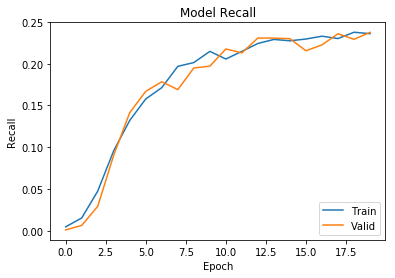

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 64)                2688      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 65        
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________
############################################
{'val_loss': [1.1772932976484298, 1.309307895352443, 1.3766551081091165, 1.3703181266784668, 1.1048924913009008, 1.0053857540090878, 0.9006647971769174, 0.9212578025956949, 0.8130802241464455, 0.7646448848148187, 0.7415363967418671, 0.7591526925563812, 0.7206991218030453, 0.6764560808738073, 0.7145857731501262, 0.6739297591149807, 0.7093714286883672, 1.4295

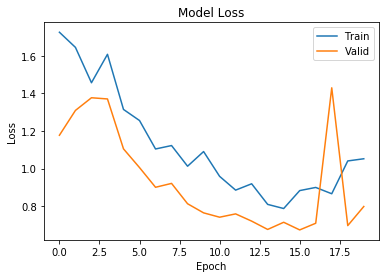

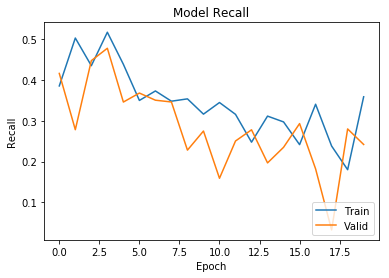

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 32)                1344      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 33        
Total params: 1,377
Trainable params: 1,377
Non-trainable params: 0
_________________________________________________________________
############################################
{'val_loss': [1.8301957537730535, 1.4914600640535354, 1.574065779397885, 1.48665560161074, 1.0153159429629643, 1.0587948319812617, 0.9421337532500426, 0.9152255122860272, 0.8546716819206873, 0.9236191521088283, 0.8662721256415049, 0.8124661336342494, 0.7829064490894476, 0.7568916571636994, 0.7516123528281847, 0.7767880231142044, 0.7022476032376289, 0.730688

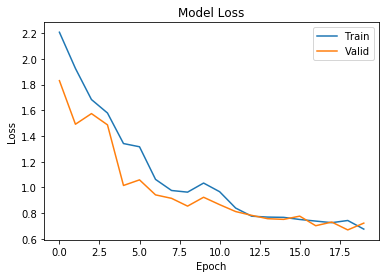

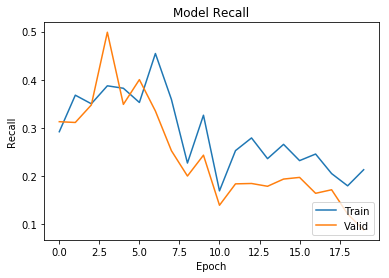

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 64)                2688      
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________
############################################
{'val_loss': [3.609781821568807, 3.5918979326883953, 3.5192346851030987, 3.5363579680522284, 2.9056321104367573, 3.0774714971582093, 3.341132256388664, 3.266639534632365, 11.668050360679626, 10.652417560418447, 10.395717593034108, 6.980125327905019, 6.8949160555998485, 5.443967626492182, 5.386503514647484, 5.157994720339775, 5.140270427862803, 5.09502564271

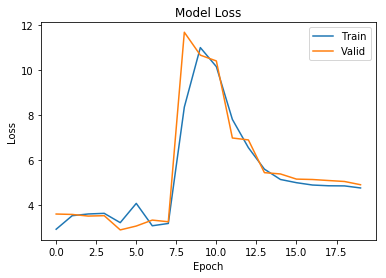

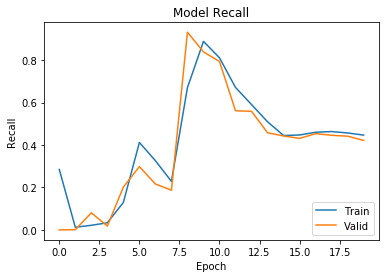

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 32)                1344      
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 33        
Total params: 1,377
Trainable params: 1,377
Non-trainable params: 0
_________________________________________________________________
############################################
{'val_loss': [3.5647256428996723, 3.577454373240471, 3.210850428044796, 3.617016383012136, 3.573885037501653, 3.588420547048251, 3.6069594184557596, 3.5909347514311474, 3.508979514737924, 3.4275090992450714, 3.609781821568807, 3.609781821568807, 3.609781821568807, 3.609781821568807, 3.609781821568807, 3.609781821568807, 3.609781821568807, 3.609781821568807,

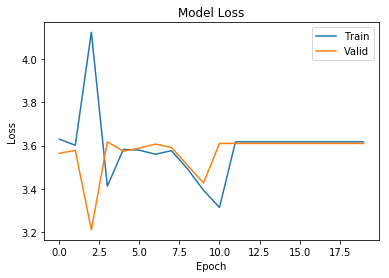

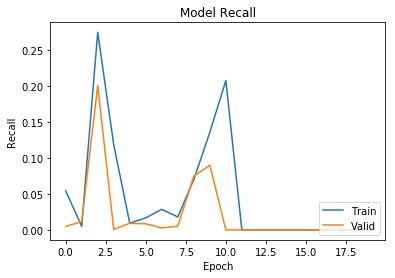

In [107]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9)
parameters = {'activation':['sigmoid', 'relu'], 
              'optimizer': ['adam', 'sgd'],
              'hiddens': [64, 32]}
fit_NNClassifier(parameters, X_train_NN, y_train_NN, X_val_NN, y_val_NN, 
                 X_train_NN.shape[1], epochs=20, batch_size=40, metrics=recall)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 64)                2688      
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 65        
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


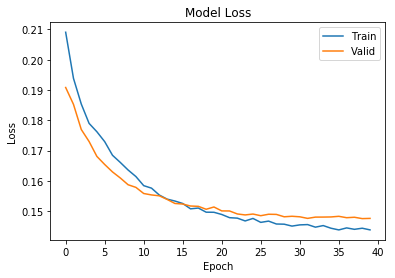

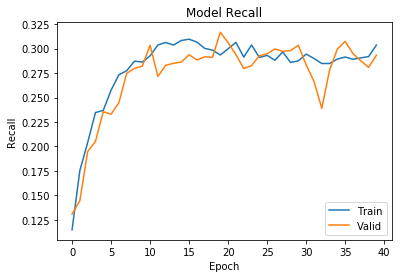

In [108]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

nnm = Sequential()
nnm.add(Dense(64, activation='relu', input_shape=(X_train_NN.shape[1], )))
nnm.add(Dropout(.15))
nnm.add(Dense(1, activation='relu', ))

from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-5, momentum=0.8)

nnm.compile(loss='mean_squared_error', optimizer=sgd, metrics=[recall])
nnm.summary()

from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='weights_best_ccd_mse_sgd.hdft', 
                               monitor=recall, verbose=0, save_best_only=False, mode='min')
hist = nnm.fit(X_train_NN, y_train_NN, validation_data=(X_val_NN, y_val_NN), epochs=40,
               batch_size=40, callbacks=[checkpointer], verbose = 0)
# print(hist.history)
plot_loss(hist)
plot_recall(hist)

In [79]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

nnm = Sequential()
nnm.add(Dense(64, activation='sigmoid', input_shape=(X_train_NN.shape[1], )))
nnm.add(Dropout(.15))
nnm.add(Dense(1, activation='sigmoid', ))

In [80]:
from keras.optimizers import SGD

sgd = SGD(lr=0.001, decay=1e-5, momentum=0.8)

nnm.compile(loss='mean_squared_error', optimizer=sgd, metrics=[recall])
nnm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                2688      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


Train on 19200 samples, validate on 4800 samples
Epoch 1/40
19200/19200 [==============================] - 1s 70us/step - loss: 0.1749 - recall: 8.6648e-04 - val_loss: 0.1693 - val_recall: 0.0000e+00

Epoch 00001: saving model to weights_best_ccd_mse_sgd.hdft
Epoch 2/40
19200/19200 [==============================] - 1s 53us/step - loss: 0.1702 - recall: 0.0015 - val_loss: 0.1664 - val_recall: 0.0000e+00

Epoch 00002: saving model to weights_best_ccd_mse_sgd.hdft
Epoch 3/40
19200/19200 [==============================] - 1s 55us/step - loss: 0.1677 - recall: 0.0034 - val_loss: 0.1638 - val_recall: 0.0021

Epoch 00003: saving model to weights_best_ccd_mse_sgd.hdft
Epoch 4/40
19200/19200 [==============================] - 1s 56us/step - loss: 0.1650 - recall: 0.0097 - val_loss: 0.1615 - val_recall: 0.0035

Epoch 00004: saving model to weights_best_ccd_mse_sgd.hdft
Epoch 5/40
19200/19200 [==============================] - 1s 56us/step - loss: 0.1633 - recall: 0.0217 - val_loss: 0.1597 - val

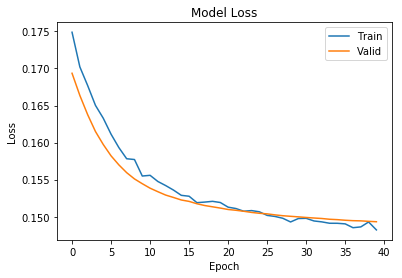

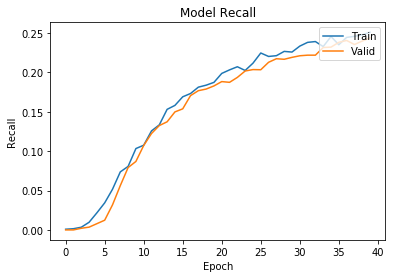

In [81]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='weights_best_ccd_mse_sgd.hdft', 
                               monitor=recall, verbose=1, save_best_only=False, mode='min')
hist = nnm.fit(X_train_NN, y_train_NN, validation_data=(X_val_NN, y_val_NN), epochs=40,
               batch_size=40, callbacks=[checkpointer], verbose = 1)
# print(hist.history)
plot_loss(hist)
plot_recall(hist)

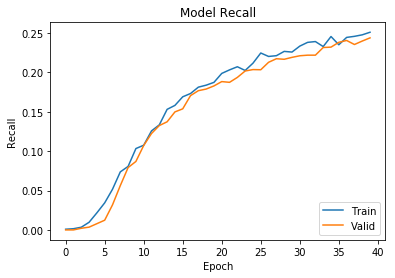

In [84]:
plot_recall(hist)